In [1]:
#!pip install shap

In [2]:
#!pip install phik -q

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import phik

from statsmodels.stats.outliers_influence import variance_inflation_factor

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder, StandardScaler, MinMaxScaler, PolynomialFeatures

from sklearn.model_selection import train_test_split

RANDOM_STATE = 42

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, make_scorer

import warnings
warnings.filterwarnings("ignore", message=".*keepdims.*")

import shap
from sklearn.inspection import permutation_importance

# Загрузка данных

In [4]:
try:
    train_job_satisfaction_rate = pd.read_csv(
        '/datasets/train_job_satisfaction_rate.csv'
    ) # тренировочная выборка Задача 1
    test_features = pd.read_csv(
        '/datasets/test_features.csv'
    ) # входные признаки тестовой выборки Задачи 1 и 2
    test_target_job_satisfaction_rate = pd.read_csv(
        '/datasets/test_target_job_satisfaction_rate.csv'
    ) # целевой признак тестовой выборки Задача 1
    train_quit = pd.read_csv(
        '/datasets/train_quit.csv'
    ) # тренировочная выборка Задача 2
    test_target_quit = pd.read_csv(
        '/datasets/test_target_quit.csv'
    ) # целевой признак тестовой выборки Задача 2
except:
    train_job_satisfaction_rate = pd.read_csv(
        'https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv'
    ) # тренировочная выборка Задача 1
    test_features = pd.read_csv(
        'https://code.s3.yandex.net/datasets/test_features.csv'
    ) # входные признаки тестовой выборки Задачи 1 и 2
    test_target_job_satisfaction_rate = pd.read_csv(
        'https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv'
    ) # целевой признак тестовой выборки Задача 1
    train_quit = pd.read_csv(
        'https://code.s3.yandex.net/datasets/train_quit.csv'
    ) # тренировочная выборка Задача 2
    test_target_quit = pd.read_csv(
        'https://code.s3.yandex.net/datasets/test_target_quit.csv'
    ) # целевой признак тестовой выборки Задача 2

In [5]:
print('Тренировочная выборка "Уровень удовлетворенности сотрудника"')
display(train_job_satisfaction_rate.head())
print('Входные признаки (тестовая выборка) для обеих задач')
display(test_features.head())
print('Целевой признак (тестовая выборка) "Уровень удовлетворенности сотрудника"')
display(test_target_job_satisfaction_rate.head())
print('Тренировочная выборка "Увольнение сотрудника"')
display(train_quit.head())
print('Целевой признак (тестовая выборка) "Увольнение сотрудника"')
display(test_target_quit.head())

Тренировочная выборка "Уровень удовлетворенности сотрудника"


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


Входные признаки (тестовая выборка) для обеих задач


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


Целевой признак (тестовая выборка) "Уровень удовлетворенности сотрудника"


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


Тренировочная выборка "Увольнение сотрудника"


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


Целевой признак (тестовая выборка) "Увольнение сотрудника"


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [6]:
print('Тренировочная выборка "Уровень удовлетворенности сотрудника"')
display(train_job_satisfaction_rate.shape)
print('Входные признаки для обеих задач (тестовая выборка)')
display(test_features.shape)
print('Целевой признак (тестовая выборка) "Уровень удовлетворенности сотрудника"')
display(test_target_job_satisfaction_rate.shape)
print('Тренировочная выборка "Увольнение сотрудника"')
display(train_quit.shape)
print('Целевой признак (тестовая выборка) "Увольнение сотрудника"')
display(test_target_quit.shape)

Тренировочная выборка "Уровень удовлетворенности сотрудника"


(4000, 10)

Входные признаки для обеих задач (тестовая выборка)


(2000, 9)

Целевой признак (тестовая выборка) "Уровень удовлетворенности сотрудника"


(2000, 2)

Тренировочная выборка "Увольнение сотрудника"


(4000, 10)

Целевой признак (тестовая выборка) "Увольнение сотрудника"


(2000, 2)

**Ход исследования:**


*А зачем нужны тренировочная и тестовая выборки?*
- *Тренировочная выборка нужна для обучения модели, а тестовая — для финальной оценки качества модели (Такое разделение позволяет проверить, насколько модель ухватила закономерности данных, и оценить качество её решений);*
- *Зачастую тестовые данные имитируют рабочие, поэтому от качества работы модели на тесте напрямую зависит её производительность на практике;*
- *Тренировочные данные можно по-разному обрабатывать, поэтому допустимо удалить несколько строк наблюдений — например, если это дубликаты или аномальные значения.*

In [7]:
print('Тренировочная выборка "Уровень удовлетворенности сотрудника"')
train_job_satisfaction_rate.info()
print('=' * 50)
print('Входные признаки для обеих задач (тестовая выборка)')
test_features.info()
print('=' * 50)
print('Целевой признак (тестовая выборка) "Уровень удовлетворенности сотрудника"')
test_target_job_satisfaction_rate.info()
print('=' * 50)
print('Тренировочная выборка "Увольнение сотрудника"')
train_quit.info()
print('=' * 50)
print('Целевой признак (тестовая выборка) "Увольнение сотрудника"')
test_target_quit.info()

Тренировочная выборка "Уровень удовлетворенности сотрудника"
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB
Входные признаки для обеих задач (тестовая выборка)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (tota

# Задача 1: предсказание уровня удовлетворённости сотрудника

## Предобработка данных

In [8]:
# сделаю для себя список датафреймов для удобства
dfs_1 = [train_job_satisfaction_rate, test_features, test_target_job_satisfaction_rate]

In [9]:
# проверка на пропуски
for df in dfs_1:
    print(df.isna().sum())
    print()

id                       0
dept                     6
level                    4
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

id                       0
dept                     2
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

id                       0
job_satisfaction_rate    0
dtype: int64



In [10]:
test_features['dept'].unique()

array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
      dtype=object)

**Ход исследования**

Есть пропущенные значения в тренировочной и тестовой выборках - составлю пайплан для заполнения пропусков в разделе подготовки данных.

In [11]:
# проверка на дубликаты
for df in dfs_1:
    print(df.duplicated().sum())
    print()

0

0

0



**Ход исследования**

- Дубликатов нет, пропуски будут устранены при подготовке перед обучением моделей;
- На выбросы проверю в ходе исследовательского анализа с помощью описательной статистики и ящиков с усами;
- Неявные дубликаты будет видно при проверке распределения признаков.

## Исследовательский анализ

### Описательная статистика

In [12]:
# создание отдельных списков для количественных (включая целевой) и категориальных признаков (train)
num_col_names_train = train_job_satisfaction_rate[
    ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']
]

cat_col_names_train = train_job_satisfaction_rate[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
]

In [13]:
# описательная статистика количественных признаков
num_col_names_train.describe()

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


In [14]:
# создание отдельных списков для количественных и категориальных признаков (test_features)
num_col_names_features = test_features[
    ['employment_years', 'supervisor_evaluation', 'salary']
]

cat_col_names_features = test_features[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']
]

In [15]:
# описательная статистика количественных признаков
num_col_names_features.describe()

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


In [16]:
# описательная статистика (test_target)
test_target_job_satisfaction_rate['job_satisfaction_rate'].describe()

count    2000.00000
mean        0.54878
std         0.22011
min         0.03000
25%         0.38000
50%         0.58000
75%         0.72000
max         1.00000
Name: job_satisfaction_rate, dtype: float64

**Ход исследования**

Статитстика выглядит нормально, нет больших отклонений от среднего, выбросы не наблюдаются, тестовые и тренировочные данные схожи по статистическим показателям.

### Частотные распределения

In [17]:
# создание функции и применение к train и test_features (категориальные признаки)
def display_value_counts(df, columns):
    for col in columns:
        display(df[col].value_counts())
        print()

display_value_counts(train_job_satisfaction_rate, cat_col_names_train)
print('-' * 50)
display_value_counts(test_features, cat_col_names_features)

dept
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: count, dtype: int64

level
junior    1894
middle    1744
sinior     358
Name: count, dtype: int64

workload
medium    2066
low       1200
high       734
Name: count, dtype: int64

last_year_promo
no     3880
yes     120
Name: count, dtype: int64

last_year_violations
no     3441
yes     559
Name: count, dtype: int64


--------------------------------------------------


dept
sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: count, dtype: int64

level
junior    974
middle    854
sinior    171
Name: count, dtype: int64

workload
medium    1043
low        593
high       363
             1
Name: count, dtype: int64

last_year_promo
no     1937
yes      63
Name: count, dtype: int64

last_year_violations
no     1738
yes     262
Name: count, dtype: int64

**Ход исследования**

Распределения train и test примерно одинаковые по соотношению признаков.

- `sales` - самый распространенный отдел;
- преобладает количество `junior` и `middle` специалистов;
- в основном уровень загруженности сотрудников `medium` и `low`;
- низкое количество повышений `last_year_promo` и штрафов `last_year_violations` за прошлый год.

### Графики

**Ход исследования**

- Построю гистограммы для числовых признаков, чтобы визуально оценить форму распределения данных (гистограммы исходят из непрерывности данных, поэтому используются bins);
- Если некоторые значения будут носить явно дискретный характер, дополнительно построю для них countplot (для каждого уникального значения вывести значение);
- Также построю countplot для категориальных признаков.

#### Гистограмма

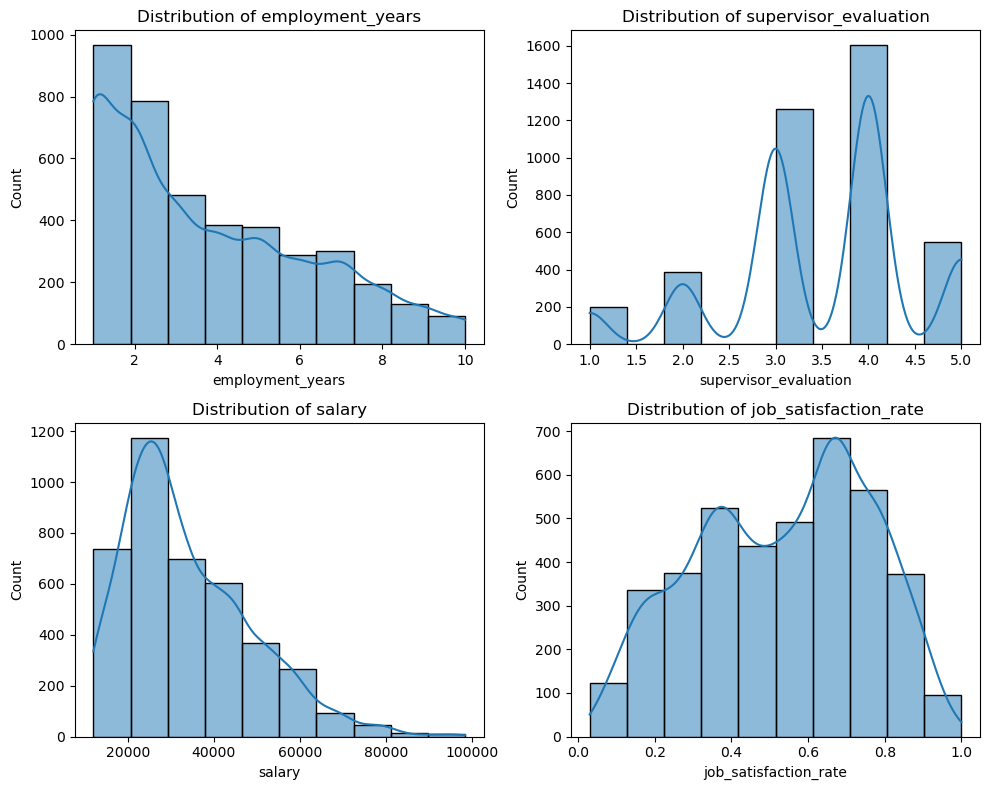

In [18]:
# гистограмма для train_job_satisfaction_rate
# 4 переменных
cols = 2   # количество столбцов — 2
rows = 2   # количество строк — 2

plt.figure(figsize=(cols * 5, rows * 4))  # размер общего холста

for i, att in enumerate(num_col_names_train, 1):  # начинаем с 1
    plt.subplot(rows, cols, i)  # размещаем i-й график в сетке
    sns.histplot(x=train_job_satisfaction_rate[att], bins=10, kde=True)
    plt.xlabel(att)
    plt.ylabel("Count")
    plt.title(f"Distribution of {att}")

plt.tight_layout()
plt.show()

**Ход исследования**

- чем больше стаж, тем меньше сотрудников (сотрудников, которые работают дольше в организации меньше, чем тех, кто работает 1-2 года);
- значения оценок качества работы сотрудника, которую дал руководитель носят дискретный характер, поэтому необходимо построить столбчатую диграмму, которая выводит значение для каждой уникальной оценки
- большее количество сотрудников зарабатывают 30 тыс. руб.;
- преобладают оценки уровня удовлетворенности 0.4 и 0.7

#### Столбчатая диаграмма

**Ход исследования**

- перезапишем признак `supervisor_evaluation` как категориальный;
- построим столбчатые диаграммы для категориальных признаков.

In [19]:
# перезапишем признак supervisor_evaluation как категориальный
num_col_names_train = train_job_satisfaction_rate[
    ['employment_years', 'salary', 'job_satisfaction_rate']
]

cat_col_names_train = train_job_satisfaction_rate[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'supervisor_evaluation']
]

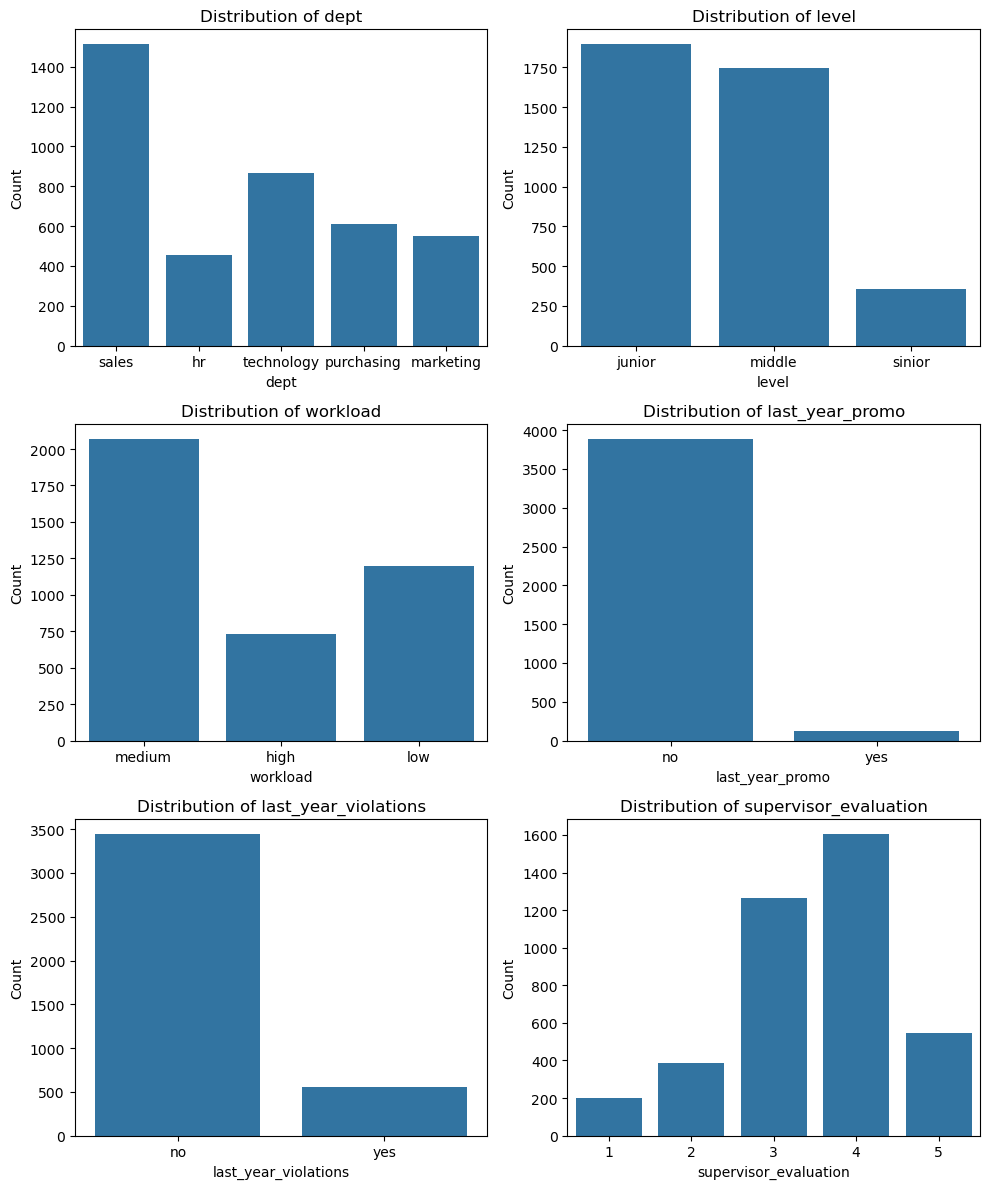

In [20]:
# столбчатая диаграмма для train_job_satisfaction_rate
# 6 переменных
cols = 2   # количество столбцов — 2
rows = 3   # количество строк — 3

plt.figure(figsize=(cols * 5, rows * 4))  # размер общего холста

for i, att in enumerate(cat_col_names_train, 1):  # начинаем с 1
    plt.subplot(rows, cols, i)  # размещаем i-й график в сетке
    sns.countplot(x=att, data=train_job_satisfaction_rate)
    plt.xlabel(att)
    plt.ylabel("Count")
    plt.title(f"Distribution of {att}")

plt.tight_layout()
plt.show()

**Ход исследования**

Можно сделать такие же выводы, как и при применении value_counts(). Плюс можно сказать, что оценка, которую дал руководитель 4 - самая распространенная.

#### Ящик с усами

**Ход исследования**

Для проверки на выбросы и оценки разброса данных дополнительно построим ящики с усами (boxplot).

In [21]:
train_job_satisfaction_rate

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
...,...,...,...,...,...,...,...,...,...,...
3995,457950,technology,junior,high,2,no,no,3,46800,0.45
3996,957499,sales,junior,medium,2,no,no,4,21600,0.68
3997,533318,sales,middle,low,7,no,no,5,24000,0.76
3998,706868,sales,junior,medium,2,no,no,3,24000,0.48


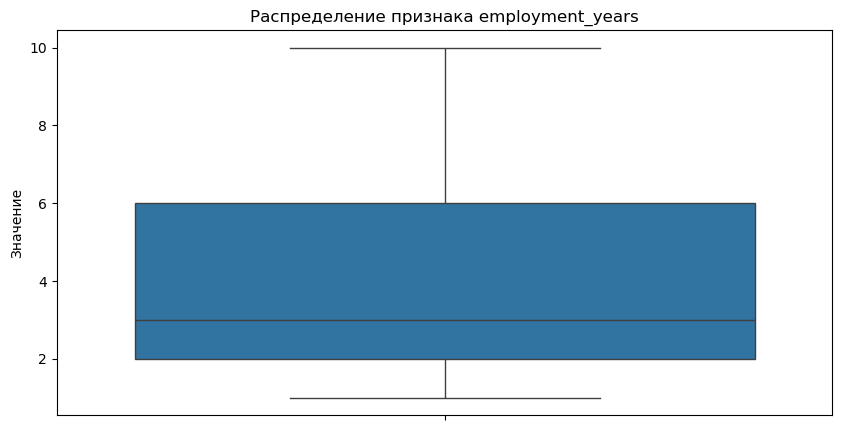

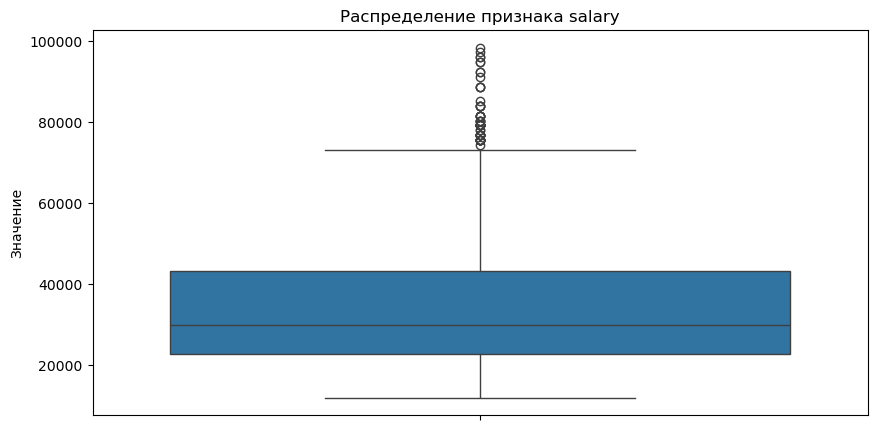

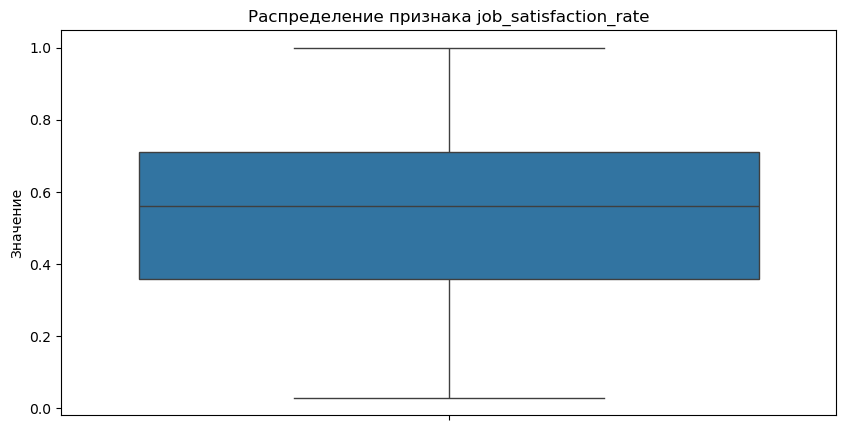

In [22]:
for col in num_col_names_train:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train_job_satisfaction_rate[col])
    plt.title(f'Распределение признака {col}')
    plt.ylabel('Значение')
    plt.show()

**Ход исследования**

В общем графики выглядят нормально за исключением `salary` - есть некоторые выбросы (примерно более 70 тыс. руб.). Но я не буду избавляться от этих данных, так как это может дать недостаточно верный прогноз при построении модели.

Далее проведем корелляционный анализ. Выявим какие признаки оказывают влияние друг на друга (проверим на наличие мультиколлинеарности), также проверим от каких признаков зависит целевой - `job_satisfaction_rate`.

## Корреляционный анализ

**Ход исследования**

Проведем корреляционный анализ с помощью Phi_K correlation.

*Phi_K correlation представляет собой инструмент для вычисления и визуализации корреляции между категориальными и количественными переменными. Она может быть полезной в анализе данных перед построением моделей машинного обучения, так как позволяет обнаружить скрытые взаимосвязи между переменными, которые могли бы остаться незамеченными при обычных методах корреляционного анализа.*

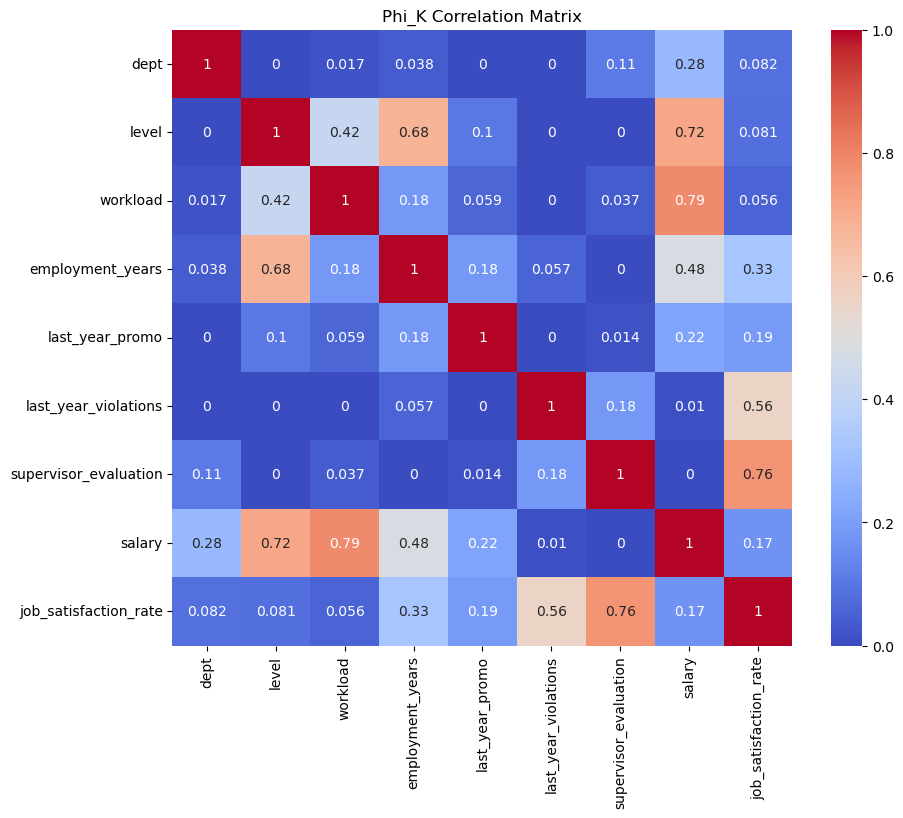

In [23]:

data_for_corr = train_job_satisfaction_rate.drop(columns=['id'])

# Вычисление матрицы корреляции между признаками
corr_matrix = data_for_corr.phik_matrix(interval_cols=num_col_names_train)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

**Ход исследования**

- целевой признак `job_satisfaction_rate` сильно зависит от `supervisor_evaluation` (0.76) и умеренно зависит от `last_year_violatons` (0.56) (отсюда гипотеза: оценка удовлетворенности работника зависит от оценки руководителя);
- сильная зависимость между `employment_years` и `level`, `salary` и `level`, `salary` и `workload`

Мультиколлинеарности нет, но есть следующие наблюдения:
1. `employment_years` vs `level` - очевидно, что уровень(junior, middle, senior) коррелирует с длительностью работы сторудника в компании. Исходя из матрицы корреляции, `level` почти не влияет на целевой признак (0.081), а `employment_years` оказывает умеренное влияние (0.33).
2. `salary` vs `level` - `salary` также не очень сильно влияет на целевой признак (0.17).
3. `salary` vs `workload` - `workload` также почти не влияет на целевой признак (0.056)

Оставляем все признаки. Далее построим диаграммы рассеяния чтобы посмотреть на типы взаимосвязей.

### Диаграммы рассеяния

**Ход исследования**

Диаграммы рассеяния будем строить для числовых признаков (смотрим какая зависимость целевого признака `job_satisfaction_rate` от входных). Также проверим, корректно ли был определен признак `supervisor_evaluation` как категориальный.

In [24]:
num_col_names_train

,employment_years,salary,job_satisfaction_rate
0,2,24000,0.58
1,2,38400,0.76
2,1,12000,0.11
3,4,18000,0.37
4,1,22800,0.20
...,...,...,...
3995,2,46800,0.45
3996,2,21600,0.68
3997,7,24000,0.76
3998,2,24000,0.48


In [25]:
# снова добавляем supervisor_evaluation в числовые признаки
num_cols_scatter = pd.concat([num_col_names_train, train_job_satisfaction_rate['supervisor_evaluation']], axis=1)

In [26]:
num_cols_scatter

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation
0,2,24000,0.58,1
1,2,38400,0.76,5
2,1,12000,0.11,2
3,4,18000,0.37,2
4,1,22800,0.20,3
...,...,...,...,...
3995,2,46800,0.45,3
3996,2,21600,0.68,4
3997,7,24000,0.76,5
3998,2,24000,0.48,3


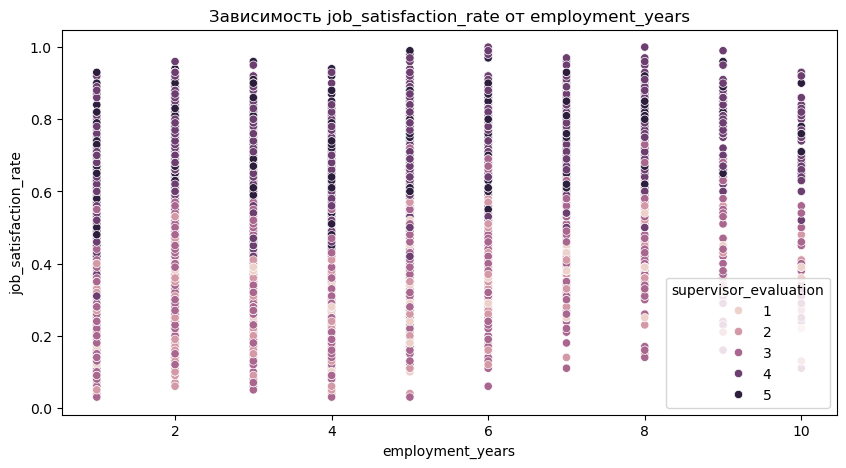

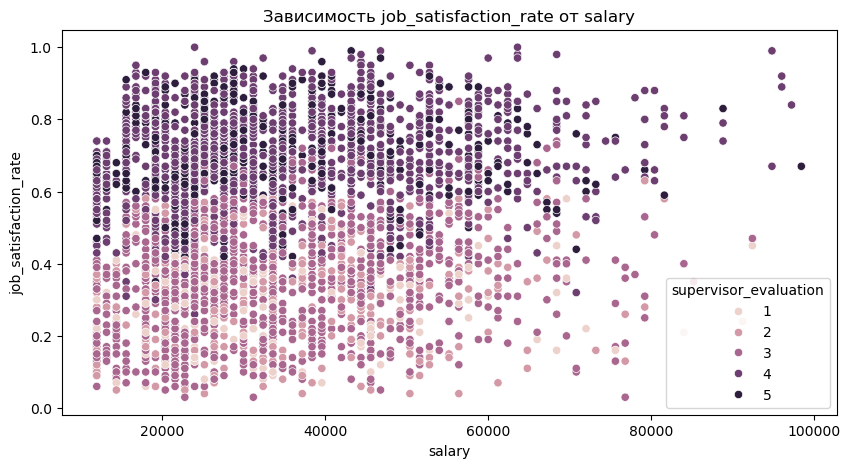

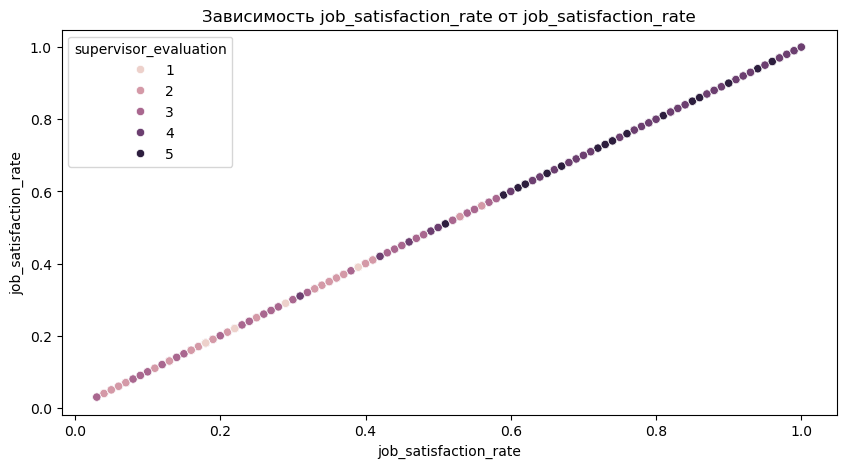

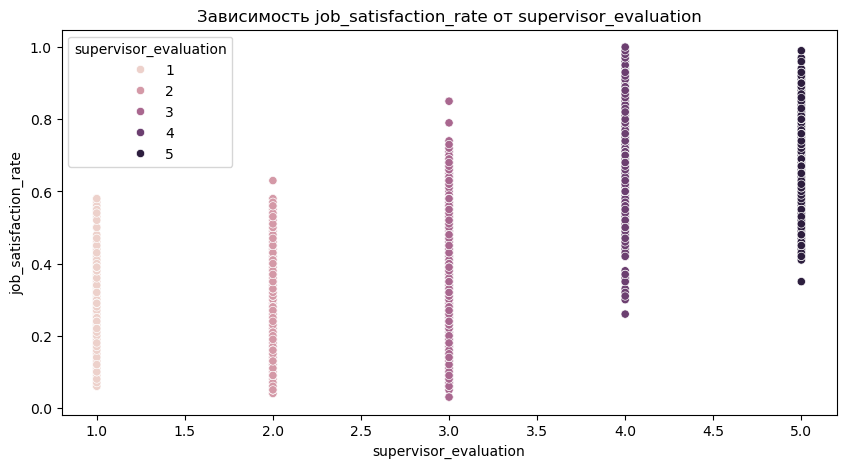

In [27]:
target = 'job_satisfaction_rate'
for feature in num_cols_scatter:
    plt.figure(figsize=(10, 5))
    sns.scatterplot(data=train_job_satisfaction_rate, x=feature, y=target, hue='supervisor_evaluation')
    plt.title(f'Зависимость {target} от {feature}')
    plt.show()

**Ход исследования**

1. Подтвержается зависимость целевого признака `job_satisfaction_rate` от `supervisor_evaluation` (точки темнее (оценки 4, 5) сосредоточены в верхней части графика 1);
2. Не наблюдается прямой зависимости на графике 2 между зп `salary` и уровнем удовлетворенности `job_satisfaction_rate`;
3. Также видно на графике 4, что уровень удовлетворенности `job_satisfaction_rate` немного растет с высокими оценками от руководителей `supervisor_evaluation`.

**Что мы имеем, прежде чем начать обучение моделей**

- данные в нормальном виде, распределены нормально (для линейной регрессии нам не важен баланс классов);
- признак `supervisor_evaluation` рассматриваем как категориальный;
- все признаки оставляем.

## Подготовка данных и обучение моделей
1. Подготовку признаков выполнить в пайплайне, дополнив пайплайн шагом предобработки. При кодировании учитывать особенности признаков и моделей и использовать как минимум два кодировщика.
2. Обучить как минимум две модели:
   - Взять одну линейную модель\
     (это будет линейная регрессия, так как предсказываем уровень удовлетворенности - числовой непрерывный признак от 0 до 1),
   - В качестве второй — дерево решений.

   Подобрать гиперпараметры как минимум для одной модели с помощью одного из известных инструментов.

In [28]:
train_job_satisfaction_rate.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [29]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [30]:
test_target_job_satisfaction_rate.head()

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


In [31]:
train_job_satisfaction_rate.shape

(4000, 10)

In [32]:
test_features.shape

(2000, 9)

In [33]:
test_target_job_satisfaction_rate.shape

(2000, 2)

In [34]:
ord_features = ['level', 'workload', 'supervisor_evaluation']
ohe_features = ['dept', 'last_year_promo', 'last_year_violations']
num_features = ['employment_years', 'salary']

In [35]:
test_features['dept'] = test_features['dept'].replace(' ', np.nan)

Нужно определиться какие данные будут `X_train`, `y_train`, `X_test`, `y_test`

На этих данных будем проверять модель:
- X_test - входные признаки (тест) (`test_features`)
- y_test - целевой признак (тест) (`test_target_job_satisfaction_rate`)

Также доступны данные:
`train_job_satisfaction_rate`- тренировочная выборка

In [36]:
# Сначала объединяем по id, затем разделим на выборки
test_data = test_features.merge(test_target_job_satisfaction_rate, on='id', how='left')

# Выборки
X_test = test_data.drop(columns=['job_satisfaction_rate'])
y_test = test_data['job_satisfaction_rate']

X_train = train_job_satisfaction_rate.drop(columns=['job_satisfaction_rate'])
y_train = train_job_satisfaction_rate['job_satisfaction_rate']

In [37]:
test_data.isna().sum()

id                       0
dept                     3
level                    1
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
job_satisfaction_rate    0
dtype: int64

In [38]:
# SimpleImputer + OHE
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='error', sparse_output=False)
        )
    ]
)


# SimpleImputer + ORD + SimpleImputer

'''
При порядковом кодировании необходимо задать порядок категоризации. 
Поэтому в параметре categories последовательно перечислим 
уровни категорий для каждого признака из списка ord_columns.
'''


ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'sinior'],  # порядок для level
                    ['low', 'medium', 'high'],       # порядок для workload
                    [1, 2, 3, 4, 5]        # порядок для supervisor_evaluation
                ], 
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


# SimpleImputer
imputer_pipe = Pipeline(
    [
        (
            'simple_imputer',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)


# только столбцы с пропусками
cols_to_impute = ['dept', 'level', 'workload']

# Заменим строки с пробелом на np.nan
for col in cols_to_impute:
    train_job_satisfaction_rate[col] = train_job_satisfaction_rate[col].replace(' ', np.nan)
    test_features[col] = test_features[col].replace(' ', np.nan)

    train_job_satisfaction_rate[cols_to_impute] = imputer_pipe.fit_transform(train_job_satisfaction_rate[cols_to_impute])
test_features[cols_to_impute] = imputer_pipe.transform(test_features[cols_to_impute])


# num_features - числовые признаки
# ord_features - признаки с естественным порядком
# ohe_features - ohe признаки

data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_features),
        ('ord', ord_pipe, ord_features),
        ('num', StandardScaler(), num_features)
    ], 
    remainder='passthrough'
)


# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])


# обучаем модель на тренировочной выборке
pipe_final.fit(X_train, y_train)

# выводим предсказанные значения тренировочной выборки
y_train_pred = pipe_final.predict(X_train)
print(f'Предсказание на обучающей выборке: {y_train_pred}')

Предсказание на обучающей выборке: [0.19364389 0.7405675  0.31529102 ... 0.81358276 0.46312247 0.04595634]


In [39]:
# функция smape
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    diff = np.abs(y_true - y_pred) / np.where(denominator == 0, 1, denominator)
    return np.mean(diff) * 100

smape_scorer = make_scorer(smape, greater_is_better=False)

In [40]:
X_test

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400
1996,109582,technology,middle,low,3,no,no,2,21600
1997,305653,technology,junior,low,1,no,no,3,14400
1998,160233,technology,middle,low,8,no,no,1,32400


In [41]:
y_test

0       0.79
1       0.72
2       0.64
3       0.60
4       0.75
        ... 
1995    0.56
1996    0.14
1997    0.11
1998    0.43
1999    0.67
Name: job_satisfaction_rate, Length: 2000, dtype: float64

In [42]:
param_grid = [
    # словарь для модели DecisionTreeRegressor() 
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

#Сохраним исходные индексы перед преобразованиями
test_index = X_test.index

randomized_search = GridSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=smape_scorer,
    #random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверка работы модели на тестовой выборке
# прогноз на тестовых данных
# предсказание с сохранением индексов
y_test_pred = randomized_search.predict(X_test)
y_test_pred_series = pd.Series(y_test_pred, index=test_index)  # используем сохраненные индексы
print(f'Метрика smape на тестовой выборке: {smape(y_test, y_test_pred_series)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

In [43]:
y_test_pred

array([0.93, 0.71, 0.65, ..., 0.18, 0.34, 0.45])

In [44]:
print(f"Размер X_test: {len(X_test)}, y_test: {len(y_test)}")

Размер X_test: 2000, y_test: 2000


# Задача 2: предсказание увольнения сотрудника из компании

## Предобработка данных

In [45]:
#train_quit.head()

In [46]:
#test_features.head()

In [47]:
#test_target_quit.head()

In [48]:
# сделаю для себя список датафреймов для удобства
dfs_2 = [train_quit, test_features, test_target_quit]

In [49]:
# проверка на пропуски
for df in dfs_2:
    print(df.isna().sum())
    print()

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
quit                     0
dtype: int64

id                       0
dept                     0
level                    0
workload                 0
employment_years         0
last_year_promo          0
last_year_violations     0
supervisor_evaluation    0
salary                   0
dtype: int64

id      0
quit    0
dtype: int64



In [50]:
# проверка на дубликаты
for df in dfs_2:
    print(df.duplicated().sum())
    print()

0

0

0



## Исследовательский анализ

### Описательная статистика

In [51]:
# создание отдельных списков для количественных и категориальных признаков (включая целевой) (train)
num_col_names_train_quit = train_quit[
    ['employment_years', 'supervisor_evaluation', 'salary']
]

cat_col_names_train_quit = train_quit[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
]

In [52]:
# описательная статистика количественных признаков
num_col_names_train_quit.describe()

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


### Частотные распределения

In [53]:
# создание функции и применение к train_quit (категориальные признаки)
def display_value_counts(df, columns):
    for col in columns:
        display(df[col].value_counts())
        print()

display_value_counts(train_quit, cat_col_names_train_quit)

dept
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: count, dtype: int64

level
junior    1949
middle    1694
sinior     357
Name: count, dtype: int64

workload
medium    2118
low       1208
high       674
Name: count, dtype: int64

last_year_promo
no     3887
yes     113
Name: count, dtype: int64

last_year_violations
no     3455
yes     545
Name: count, dtype: int64

quit
no     2872
yes    1128
Name: count, dtype: int64

### Графики

#### Гистограмма

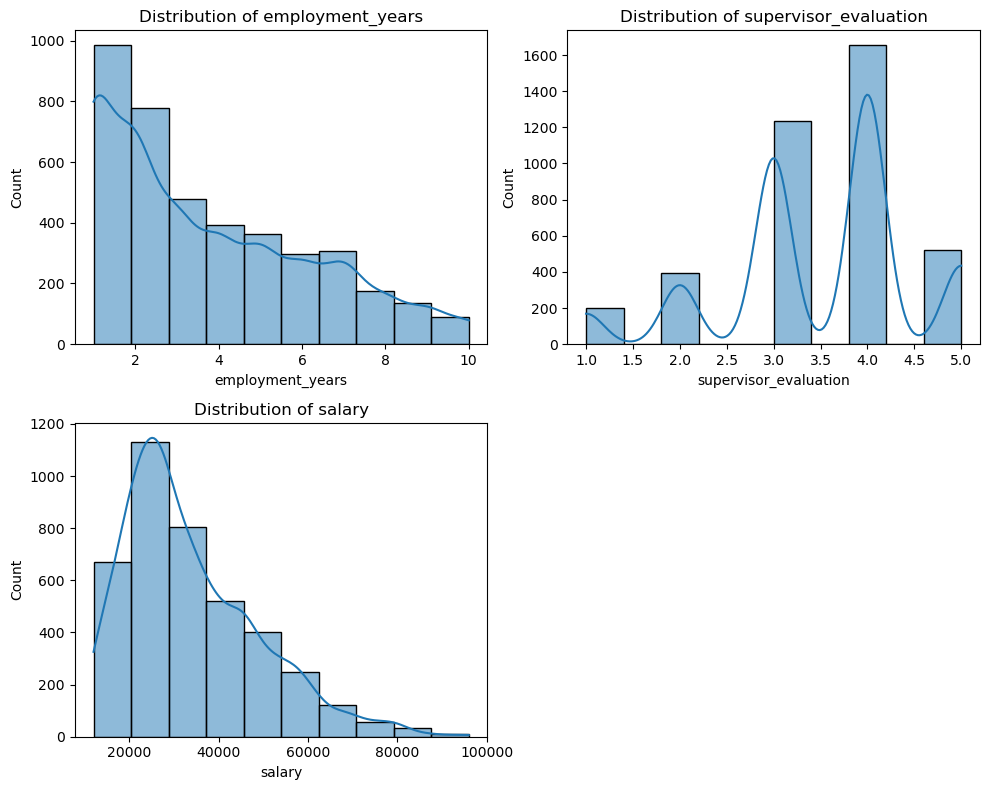

In [54]:
# гистограмма для train_quit
# 3 переменных
cols = 2   # количество столбцов — 2
rows = 2   # количество строк — 2

plt.figure(figsize=(cols * 5, rows * 4))  # размер общего холста

for i, att in enumerate(num_col_names_train_quit, 1):  # начинаем с 1
    plt.subplot(rows, cols, i)  # размещаем i-й график в сетке
    sns.histplot(x=train_quit[att], bins=10, kde=True)
    plt.xlabel(att)
    plt.ylabel("Count")
    plt.title(f"Distribution of {att}")

plt.tight_layout()
plt.show()

#### Столбчатая диаграмма

In [55]:
# перезапишем признак supervisor_evaluation как категориальный
num_col_names_train_quit = train_quit[
    ['employment_years', 'salary']
]

cat_col_names_train_quit = train_quit[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit', 'supervisor_evaluation']
]

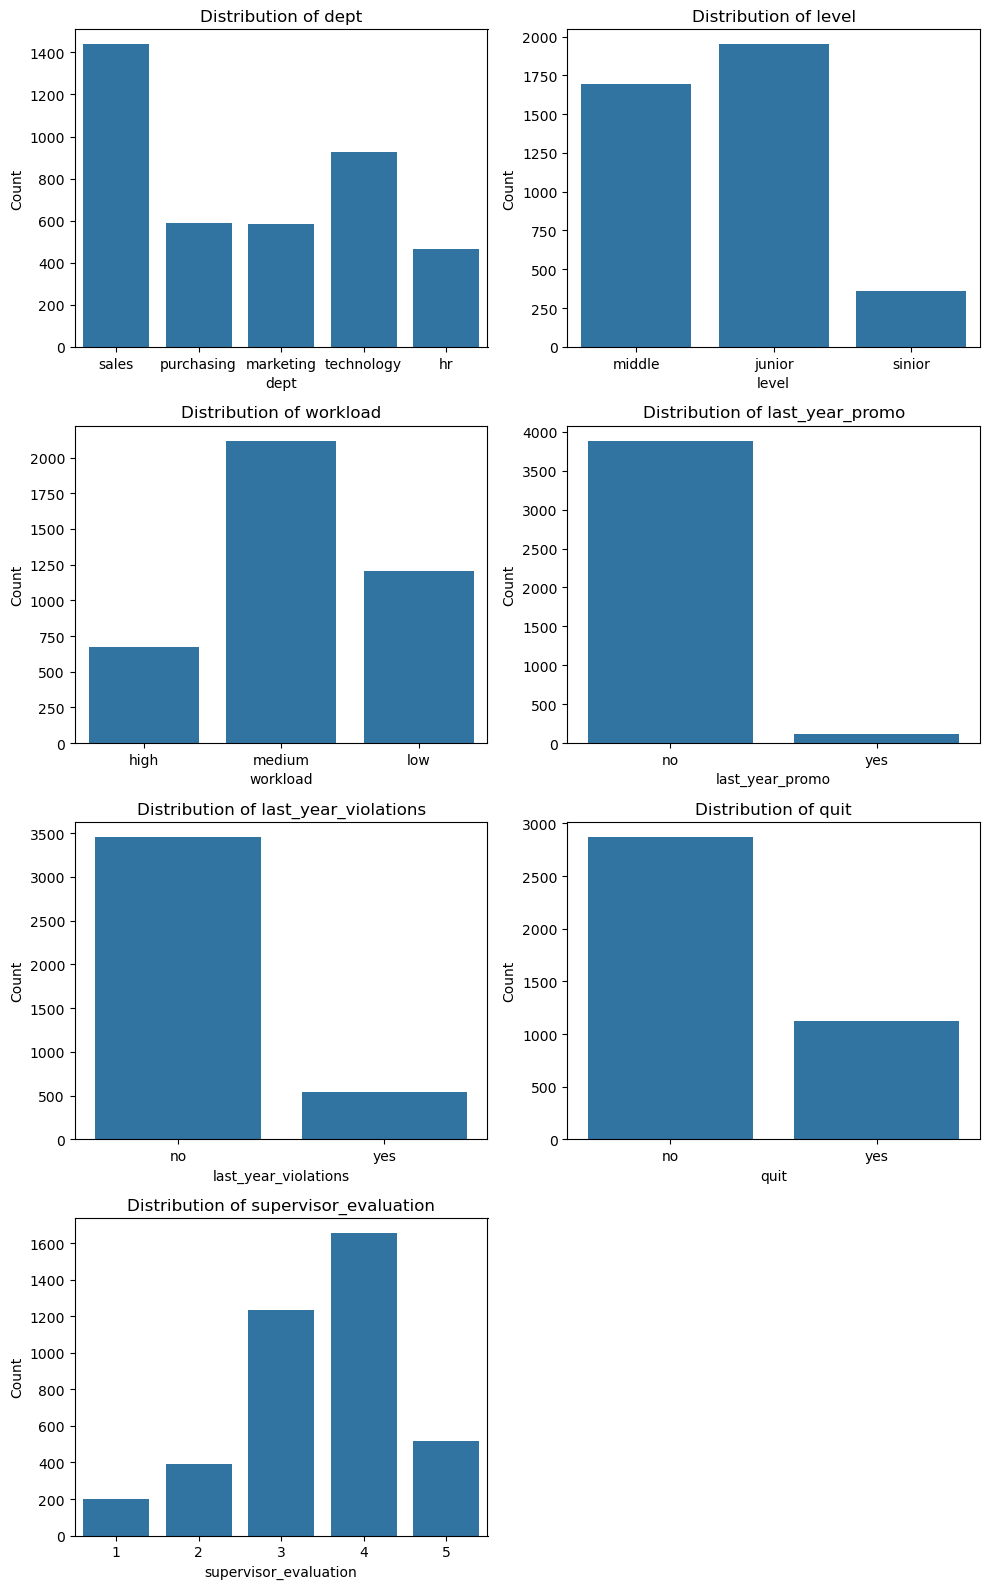

In [56]:
# столбчатая диаграмма для train_quit
# 7 переменных
cols = 2   # количество столбцов — 2
rows = 4   # количество строк — 4

plt.figure(figsize=(cols * 5, rows * 4))  # размер общего холста

for i, att in enumerate(cat_col_names_train_quit, 1):  # начинаем с 1
    plt.subplot(rows, cols, i)  # размещаем i-й график в сетке
    sns.countplot(x=att, data=train_quit)
    plt.xlabel(att)
    plt.ylabel("Count")
    plt.title(f"Distribution of {att}")

plt.tight_layout()
plt.show()

#### Ящик с усами

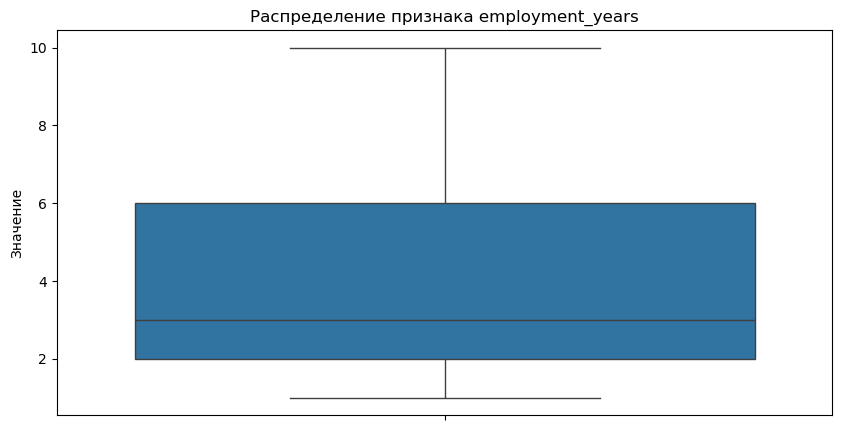

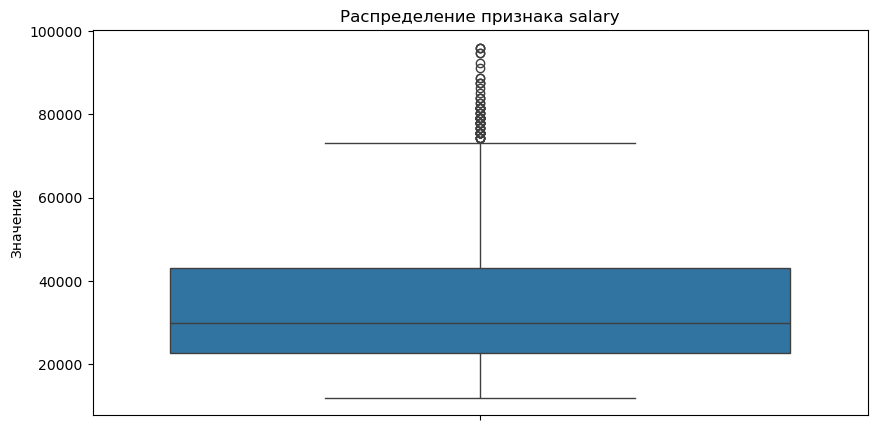

In [57]:
for col in num_col_names_train_quit:
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=train_quit[col])
    plt.title(f'Распределение признака {col}')
    plt.ylabel('Значение')
    plt.show()

## Корреляционный анализ

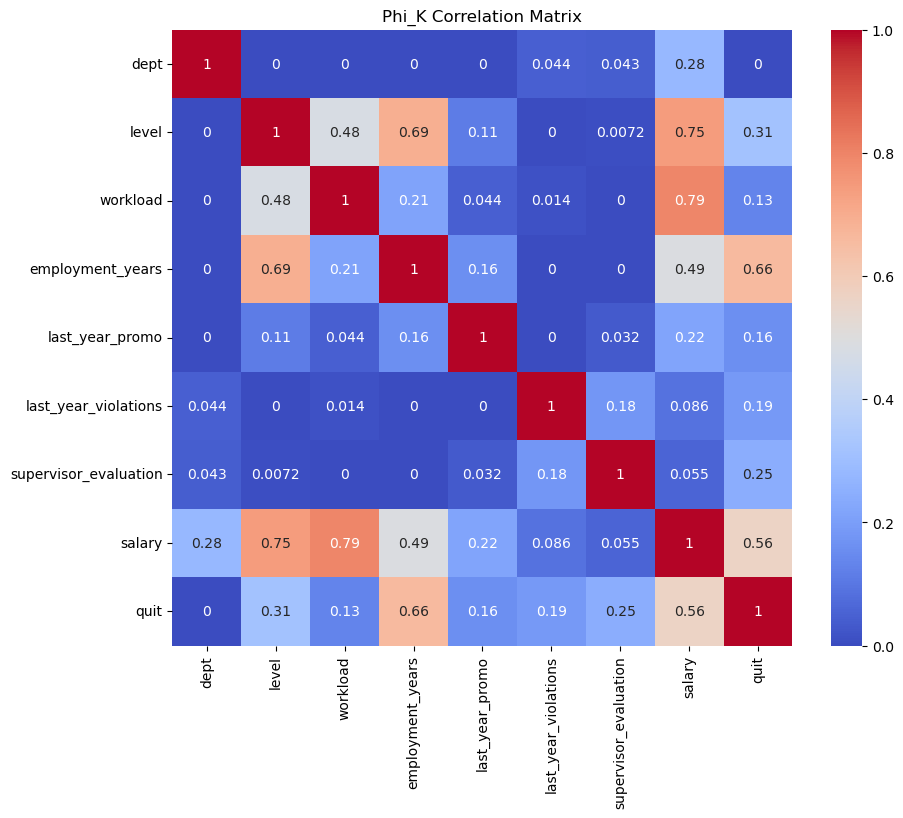

In [58]:
data_for_corr = train_quit.drop(columns=['id'])

# Вычисление матрицы корреляции между признаками данных
corr_matrix = data_for_corr.phik_matrix(interval_cols=num_col_names_train_quit)

# Визуализация
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Phi_K Correlation Matrix')
plt.show()

## Портрет «уволившегося сотрудника»

**Отдел с наибольшей текучкой:**

In [59]:
# Группировка по отделам
dept_turnover = train_quit[train_quit['quit'] == 'yes']['dept'].value_counts(normalize=True)
print("Доля уволившихся по отделам:\n", dept_turnover)

Доля уволившихся по отделам:
 dept
sales         0.360816
technology    0.244681
purchasing    0.147163
marketing     0.144504
hr            0.102837
Name: proportion, dtype: float64


**Уровень загруженности:**

In [60]:
# Сравнение нагрузки
workload_comparison = train_quit.groupby('quit')['workload'].value_counts(normalize=True)
print("Средняя загруженность:\n", workload_comparison)

Средняя загруженность:
 quit  workload
no    medium      0.567549
      low         0.239903
      high        0.192549
yes   low         0.460106
      medium      0.432624
      high        0.107270
Name: proportion, dtype: float64


**Уровень зарплаты:**

In [61]:
# Сравнение зарплат
salary_comparison = train_quit.groupby('quit')['salary'].mean()
print("Средняя зарплата:\n", salary_comparison)

Средняя зарплата:
 quit
no     37702.228412
yes    23885.106383
Name: salary, dtype: float64


**Длительность работы:**

In [62]:
work_duration = train_quit[train_quit['quit'] == 'yes']['employment_years'].value_counts(normalize=True)
print("Доля уволившихся:\n", work_duration)

Доля уволившихся:
 employment_years
1     0.531028
2     0.257092
3     0.144504
4     0.023936
5     0.020390
6     0.008865
7     0.006206
10    0.002660
8     0.002660
9     0.002660
Name: proportion, dtype: float64


**Оценки от руководителей:**

In [63]:
# Распределение оценок
manager_rating = train_quit[train_quit['quit'] == 'yes']['supervisor_evaluation'].value_counts(normalize=True)
print("Доля уволившихся:\n", manager_rating)

Доля уволившихся:
 supervisor_evaluation
3    0.463652
4    0.253546
2    0.145390
1    0.084220
5    0.053191
Name: proportion, dtype: float64


**Итоговый портрет:**

Типичный уволившийся сторудник - это:
- сотрудник из отдела продаж;
- с низкой или средней загруженностью;
- с зарплатой ниже среднего;
- работающий первые 1-2 года в компании;
- оцениваемый руководителями на 3 или 4.

## Гипотеза
Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

Проверить это утверждение: визуализировать и сравнить распределения признака `job_satisfaction_rate` для ушедших и оставшихся сотрудников. Использовать данные с обоими целевыми признаками тестовой выборки.

- Нужно соединить `test_target_job_satisfaction_rate` и `test_target_quit`;
- Фильтровать по ['quit'] == 'yes' и ['quit'] == 'no';
- Построить гистограммы распределения `job_satisfaction_rate` по двум выборкам (уволился/не уволился);
- Сделать вывод.

In [64]:
#test_target_job_satisfaction_rate.head()

In [65]:
#test_target_quit.head()

In [66]:
#test_target_job_satisfaction_rate.shape

In [67]:
#test_target_quit.shape

In [68]:
target_features = test_target_job_satisfaction_rate.merge(test_target_quit, on='id', how='left')
target_features.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
2,418490,0.60,yes
3,555320,0.72,no
4,826430,0.08,yes


In [69]:
#target_features.shape

In [70]:
target_quit_yes = target_features[target_features['quit'] == 'yes']
target_quit_yes.head()

,id,job_satisfaction_rate,quit
2,418490,0.60,yes
4,826430,0.08,yes
20,508688,0.58,yes
29,343440,0.35,yes
30,622918,0.77,yes


In [71]:
#target_quit_yes.shape

In [72]:
target_quit_no = target_features[target_features['quit'] == 'no']
target_quit_no.head()

,id,job_satisfaction_rate,quit
0,130604,0.74,no
1,825977,0.75,no
3,555320,0.72,no
5,817219,0.76,no
6,269033,0.64,no


In [73]:
#target_quit_no.shape

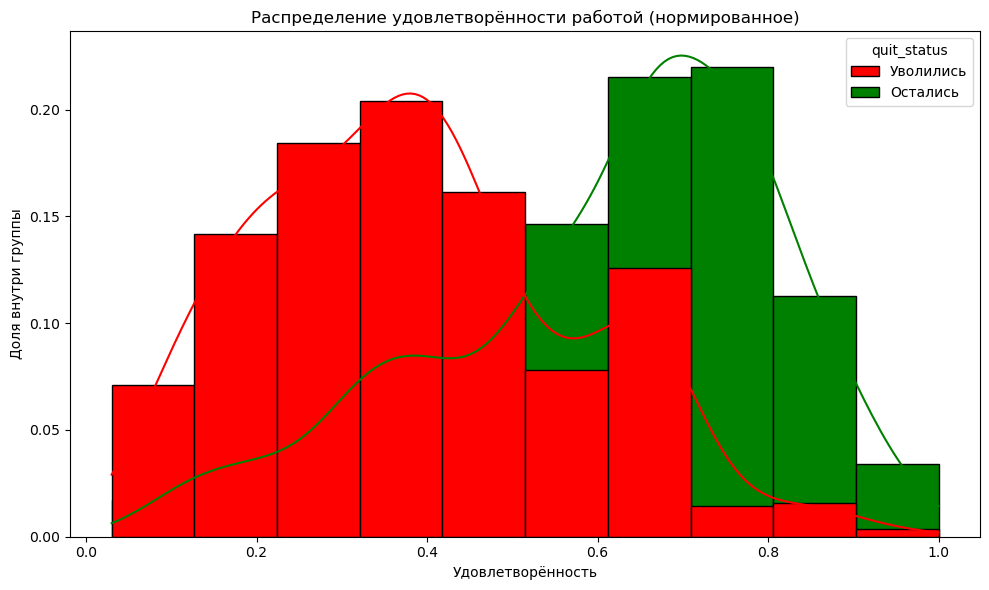

In [74]:
# Объединяем данные в один DataFrame с меткой группы
df_yes = target_quit_yes.assign(quit_status='Уволились')
df_no = target_quit_no.assign(quit_status='Остались')
combined_df = pd.concat([df_yes, df_no])

plt.figure(figsize=(10, 6))
sns.histplot(
    data=combined_df,
    x='job_satisfaction_rate',
    hue='quit_status',
    bins=10,
    alpha=1,
    palette={'Уволились': 'red', 'Остались': 'green'},
    kde=True,
    stat='probability',  # нормализация
    common_norm=False
)

plt.title('Распределение удовлетворённости работой (нормированное)')
plt.xlabel('Удовлетворённость')
plt.ylabel('Доля внутри группы')
plt.tight_layout()
plt.show();

**Вывод**

Гипотеза о том, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник подтверждается. Об этом говорят гистограммы распределения.

Наблюдается смещение кривой красного цвета (уволившиеся) влево - у большинства уволившихся сотрудников низкая удовлетворенность работой.

## Задача 2 Подготовка данных и обучение моделей
1. Добавить `job_satisfaction_rate`, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи.
2. Подготовить признаки так же, как и в первой задаче: 
   - выполнить подготовку в пайплайне;
   - при кодировании учитывать особенности признаков и моделей и использовать как минимум два кодировщика.
3. Обучить как минимум три модели. Как минимум для двух из них подобрать гиперпараметры.

In [75]:
train_quit.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [76]:
test_features.head()

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [77]:
test_target_quit.head()

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


In [78]:
train_quit.shape

(4000, 10)

In [79]:
test_features.shape

(2000, 9)

In [80]:
test_target_quit.shape

(2000, 2)

In [81]:
# создание отдельных списков для количественных и категориальных признаков (включая целевой) (train)
num_col_names_train_quit = train_quit[
    ['employment_years', 'supervisor_evaluation', 'salary']
]

cat_col_names_train_quit = train_quit[
    ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']
]

In [82]:
# предсказанные значения job_satisfaction_rate для выборки train_job_satisfaction_rate
job_satisfaction_rate_pred_train = pd.DataFrame(y_train_pred, columns=['job_satisfaction_rate_pred'])
job_satisfaction_rate_pred_train

,job_satisfaction_rate_pred
0,0.193644
1,0.740568
2,0.315291
3,0.405457
4,0.410195
...,...
3995,0.498961
3996,0.567703
3997,0.813583
3998,0.463122


In [83]:
# прогнозные значения лучшей модели
job_satisfaction_rate_pred = pd.DataFrame(y_test_pred, columns=['job_satisfaction_rate_pred'])
job_satisfaction_rate_pred

,job_satisfaction_rate_pred
0,0.93
1,0.71
2,0.65
3,0.65
4,0.76
...,...
1995,0.46
1996,0.15
1997,0.18
1998,0.34


In [84]:
# предсказанные значения job_satisfaction_rate тестовой выборки присоед. к входным тестовым признакам
test_features_pred = test_features.join(job_satisfaction_rate_pred)
test_features_pred

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred
0,485046,marketing,junior,medium,2,no,no,5,28800,0.93
1,686555,hr,junior,medium,1,no,no,4,30000,0.71
2,467458,sales,middle,low,5,no,no,4,19200,0.65
3,418655,sales,middle,low,6,no,no,4,19200,0.65
4,789145,hr,middle,medium,5,no,no,5,40800,0.76
...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.46
1996,109582,technology,middle,low,3,no,no,2,21600,0.15
1997,305653,technology,junior,low,1,no,no,3,14400,0.18
1998,160233,technology,middle,low,8,no,no,1,32400,0.34


In [85]:
# предсказанные значения job_satisfaction_rate тестовой выборки присоед. к трен. признакам
train_quit_pred = train_quit.join(job_satisfaction_rate_pred_train)
train_quit_pred

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
0,723290,sales,middle,high,2,no,no,4,54000,no,0.193644
1,814010,sales,junior,medium,2,no,no,4,27600,no,0.740568
2,155091,purchasing,middle,medium,5,no,no,1,37200,no,0.315291
3,257132,sales,junior,medium,2,no,yes,3,24000,yes,0.405457
4,910140,marketing,junior,medium,2,no,no,5,25200,no,0.410195
...,...,...,...,...,...,...,...,...,...,...,...
3995,588809,sales,junior,medium,4,no,no,3,26400,no,0.498961
3996,672059,sales,middle,high,9,no,no,4,52800,no,0.567703
3997,536432,purchasing,junior,low,2,no,yes,4,12000,yes,0.813583
3998,692133,purchasing,middle,medium,2,no,no,4,33600,no,0.463122


In [86]:
# Сначала объединяем данные по id
test_data = test_features_pred.merge(test_target_quit, on='id', how='left')

# Делим на выборки
X_test = test_data.drop(columns=['quit'])
y_test = test_data['quit']
X_train = train_quit_pred.drop(columns='quit')
y_train = train_quit_pred['quit']

# Преобразуем целевую переменную
label_encoder = LabelEncoder()

# Кодируем целевую переменную в тренировочном и тестовом наборе
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [87]:
#label_encoder.classes_

0 - 'no', 1 - 'yes'

In [88]:
test_data

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate_pred,quit
0,485046,marketing,junior,medium,2,no,no,5,28800,0.93,no
1,686555,hr,junior,medium,1,no,no,4,30000,0.71,no
2,467458,sales,middle,low,5,no,no,4,19200,0.65,no
3,418655,sales,middle,low,6,no,no,4,19200,0.65,no
4,789145,hr,middle,medium,5,no,no,5,40800,0.76,no
...,...,...,...,...,...,...,...,...,...,...,...
1995,393147,marketing,junior,low,3,no,no,3,20400,0.46,yes
1996,109582,technology,middle,low,3,no,no,2,21600,0.15,yes
1997,305653,technology,junior,low,1,no,no,3,14400,0.18,yes
1998,160233,technology,middle,low,8,no,no,1,32400,0.34,no


In [89]:
num_features = ['employment_years', 'job_satisfaction_rate_pred']

In [90]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_features),
        ('ord', ord_pipe, ord_features),
        ('num', StandardScaler(), num_features)
    ], 
    remainder='passthrough'
)

In [91]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train_encoded)

print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

# проверка работы модели на тестовой выборке
# прогноз на тестовых данных
y_test_proba = randomized_search.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_encoded, y_test_proba)}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                       

# Вывод
**Этапы работы**

1. Первичный анализ и подготовка данных:

   - Анализ распределений, выбросов, категорий.

   - Обнаружены пропуски, были корректно заполнены в пайплайне.

   Вывод: статистики train/test схожи, данные адекватны для моделирования.

2. EDA и корреляционный анализ:

   - Уровень удовлетворённости сильно коррелирует с оценкой руководителя и умеренно с количеством нарушений.

   - Мультиколлинеарность между признаками не обнаружена.

3. Предобработка признаков:

   - Для категориальных признаков с порядком использован OrdinalEncoder.

   - Для остальных — OneHotEncoder.

   - Стандартизация/нормализация числовых признаков с помощью StandardScaler / MinMaxScaler.

4. Построение моделей:

   - **Для задачи регрессии: лучшая модель — DecisionTreeRegressor(random_state=42).**

   - SMAPE на валидации: 17.35

   - **SMAPE на тесте: 15.7 — неплохой результат.**

   - **Для задачи классификации: лучшая модель — LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear').**

   - **ROC-AUC на тесте: 0.89 — хороший результат.**
   
**Выводы и рекомендации**

- Для первой задачи (удовлетворённость): возможно доработать модель:

   - Добавить генерацию новых признаков (например, взаимодействия, полиномиальные признаки, binning);

   - Попробовать регуляризацию;

   - Применить более сложный отбор признаков: SHAP, Permutation Importance.

- Для второй задачи (отток): получена интерпретируемая и достаточно точная модель:

   - Возможность использовать в реальном бизнес-процессе;

   - Можно регулярно переобучать модель на новых данных;

   - Использовать предсказания в HR-системе: ранние оповещения, предложения по удержанию.